Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [371]:
# Load the dataset and necessary modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.datasets import load_digits
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import TruncatedSVD

X, y = load_digits(return_X_y=True)

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

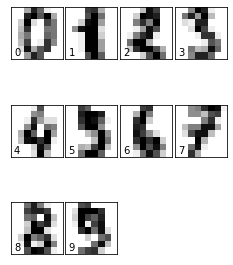

In [184]:
fig = plt.figure(figsize=(3, 4))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

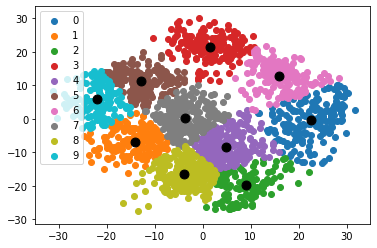

In [318]:
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
data, labels = load_digits(return_X_y=True)

### K-means clustering
# reduce dimensions
pca = PCA(2)
scaled_data = pca.fit_transform(data)

(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
# kmeans = cluster.KMeans(init="k-means++", n_clusters=n_digits, n_init=100,
#                 random_state=0)
kmeans = cluster.KMeans(n_clusters= 10)
label = kmeans.fit_predict(scaled_data)

# Getting unique labels
centroids = kmeans.cluster_centers_
unique_labels = np.unique(label)

#plotting the results:
 
for i in unique_labels:
    plt.scatter(scaled_data[label == i , 0], scaled_data[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

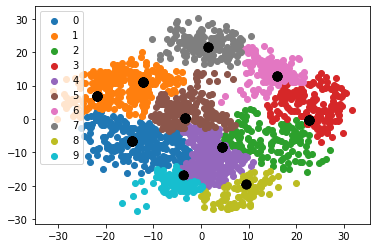

In [317]:
### Hierarchical clustering

# reduce dimensions
pca = PCA(2)
scaled_data = pca.fit_transform(data)

(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
# kmeans = cluster.KMeans(init="k-means++", n_clusters=n_digits, n_init=100,
#                 random_state=0)
ac = cluster.AgglomerativeClustering(n_clusters= 10)
label = ac.fit_predict(scaled_data)

# Getting unique labels
clf = NearestCentroid()
clf.fit(scaled_data, labels_ac)
centers = clf.centroids_
unique_labels = np.unique(label)

#plotting the results:
 
for i in unique_labels:
    plt.scatter(scaled_data[label == i , 0], scaled_data[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

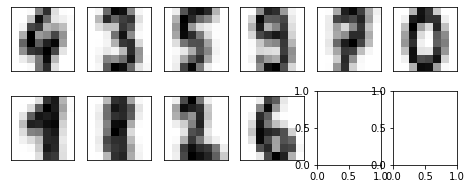

In [345]:
from sklearn.datasets import load_digits
from scipy.stats import mode

digits = load_digits()
kmeans = cluster.KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)

# labels = np.zeros_like(clusters)
# for i in range(10):
#     mask = (clusters == i)
#     labels[mask] = mode(digits.target[mask])[0]

# label = np.unique(labels)
# kmeans.cluster_centers_.shape

fig, ax = plt.subplots(2, 6, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)


for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
    #axi.text(0, 7, str(labels[i]))

In [492]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
ac = cluster.AgglomerativeClustering(n_clusters= 10)
label = ac.fit_predict(scaled_data) 
centroids = ac.labels_
print(len(centroids))
#print(label)
# for axi, lab in zip(ax.flat, label):
#     axi.set(xticks=[], yticks=[])
#     axi.imshow(label, interpolation='nearest', cmap=plt.cm.binary)

label_s = np.zeros_like(label)
for i in range(10):
    mask = (label == i)
    #print(mask)
    label_s[mask] = mode(digits.target[mask])[0]

label_s = np.unique(labels)

Z = linkage(scaled_data, method='ward')
clusters_ac = fcluster(Z, 10, criterion='distance')
print(len(clusters_ac))

# for axi, lab in zip(ax.flat, labels):
#     axi.set(xticks=[], yticks=[])
#     axi.imshow(lab, interpolation='nearest', cmap=plt.cm.binary)

# fig = plt.figure(figsize=(3, 4))  # figure size in inches
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# for i in range(10):
#     mask = (clusters_ac == i)
#     ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
#     ax.imshow(X.reshape(-1, 8, 8)[mask].mean(axis=0), cmap=plt.cm.binary, interpolation='nearest')
#     # label the image with the target value
#     ax.text(0, 7, str(digits.target[i]))

1797
1797


В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

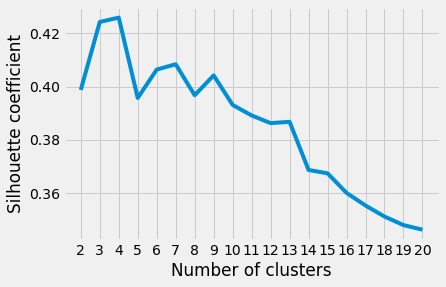

In [364]:
### Kmeans clustering and silhouette score
# A list holds the silhouette coefficients for each k
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 100,
   "random_state": 42,
   }
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 21):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 21), silhouette_coefficients)
plt.xticks(range(2, 21))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

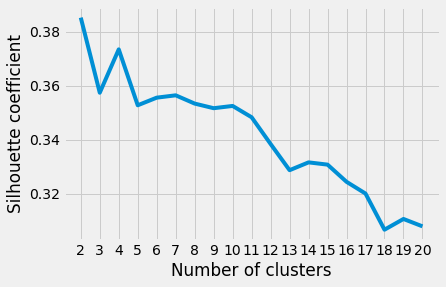

In [369]:
### Agglomerative clustering and silhouette score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 21):
    ac = cluster.AgglomerativeClustering(n_clusters=k)
    ac.fit(scaled_data)
    score = silhouette_score(scaled_data, ac.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 21), silhouette_coefficients)
plt.xticks(range(2, 21))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

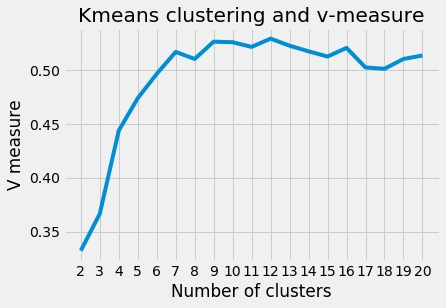

In [373]:
### Kmeans clustering and v-measure

# A list holds the silhouette coefficients for each k
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 100,
   "random_state": 42,
   }
v_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, 21):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    y_pred = kmeans.fit_predict(scaled_data)
    score = v_measure_score(y, y_pred)
    v_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 21), v_coefficients)
plt.xticks(range(2, 21))
plt.xlabel("Number of clusters")
plt.ylabel("V measure")
plt.title("Kmeans clustering and v-measure")
plt.show()

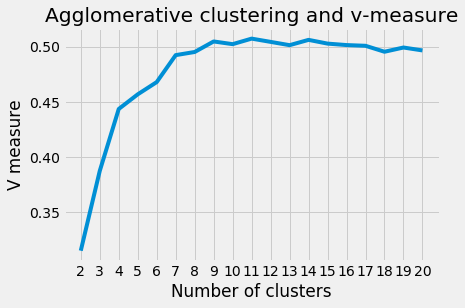

In [374]:
### Agglomerative clustering and v-measure

# A list holds the v coefficients for each k
v_coefficients = []

# Start at 2 clusters for v coefficient
for k in range(2, 21):
    ac = cluster.AgglomerativeClustering(n_clusters=k)
    y_pred = ac.fit_predict(scaled_data)
    score = v_measure_score(y, y_pred)
    v_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 21), v_coefficients)
plt.xticks(range(2, 21))
plt.xlabel("Number of clusters")
plt.ylabel("V measure")
plt.title("Agglomerative clustering and v-measure")
plt.show()

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

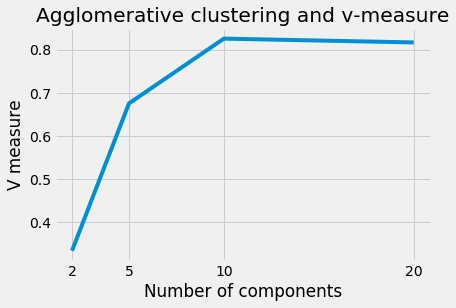

In [412]:
# Agglomerative clustering and TruncatedSVD
X, y = load_digits(return_X_y=True)
n_components = [2, 5, 10, 20]
v_coefficients = []
for i in n_components:
    svd = TruncatedSVD(n_components=i)
    new_x = svd.fit_transform(X)
    
    ac = cluster.AgglomerativeClustering(n_clusters=10)
    y_pred = ac.fit_predict(new_x)
    score = v_measure_score(y, y_pred)
    v_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(n_components, v_coefficients)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("V measure")
plt.title("Agglomerative clustering and v measure")
plt.show()

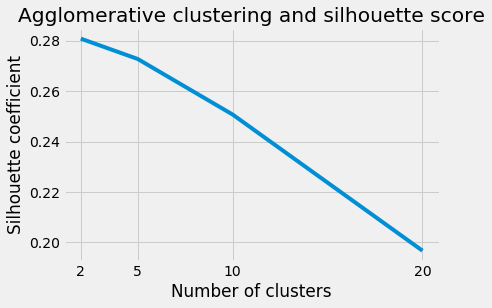

In [413]:
# Agglomerative clustering and TruncatedSVD
X, y = load_digits(return_X_y=True)
silhouette_coefficients = []
for i in n_components:
    svd = TruncatedSVD(n_components=i)
    new_x = svd.fit_transform(X)
    ac = cluster.AgglomerativeClustering(n_clusters=10)
    ac.fit(new_x)
    score = silhouette_score(new_x, ac.labels_)
    silhouette_coefficients.append(score)
    

plt.style.use("fivethirtyeight")
plt.plot(n_components, silhouette_coefficients)
plt.xticks(n_components)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.title("Agglomerative clustering and silhouette score")
plt.show()

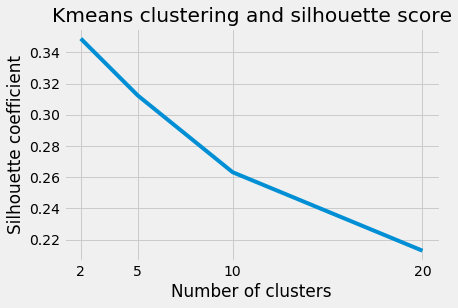

In [411]:
# Kmeans clustering and TruncatedSVD
X, y = load_digits(return_X_y=True)
silhouette_coefficients = []
for i in n_components:
    svd = TruncatedSVD(n_components=i)
    new_x = svd.fit_transform(X)
    kmeans = cluster.KMeans(n_clusters=10)
    kmeans.fit(new_x)
    score = silhouette_score(new_x, kmeans.labels_)
    silhouette_coefficients.append(score)
    

plt.style.use("fivethirtyeight")
plt.plot(n_components, silhouette_coefficients)
plt.xticks(n_components)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.title("Kmeans clustering and silhouette score")
plt.show()

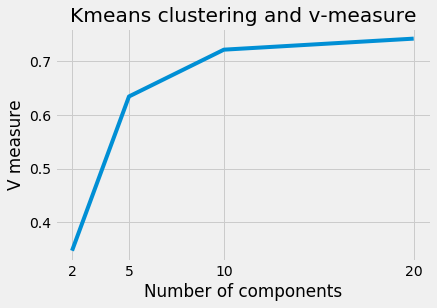

In [409]:
# Kmeans clustering and TruncatedSVD
X, y = load_digits(return_X_y=True)
n_components = [2, 5, 10, 20]
v_coefficients = []
for i in n_components:
    svd = TruncatedSVD(n_components=i)
    new_x = svd.fit_transform(X)
    
    kmeans = cluster.KMeans(n_clusters=10)
    y_pred = kmeans.fit_predict(new_x)
#     print(y_pred)
#     print(y)
    score = v_measure_score(y, y_pred)
    v_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(n_components, v_coefficients)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("V measure")
plt.title("Kmeans clustering and v measure")
plt.show()

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [490]:
import numpy as np
from sklearn.manifold import TSNE
X, y = load_digits(return_X_y=True)

X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1797, 2)

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

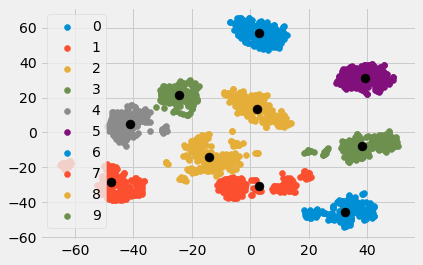

In [484]:
# Kmeans clustering

(n_samples, n_features), n_digits = X_embedded.shape, np.unique(y).size
# kmeans = cluster.KMeans(init="k-means++", n_clusters=n_digits, n_init=100,
#                 random_state=0)
kmeans = cluster.KMeans(n_clusters=10)
label = kmeans.fit_predict(X_embedded)

# Getting unique labels
centroids = kmeans.cluster_centers_
unique_labels = np.unique(label)

#plotting the results:
 
for i in unique_labels:
    plt.scatter(X_embedded[label == i , 0], X_embedded[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

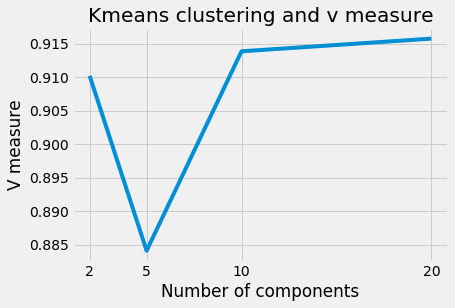

In [487]:
# Kmeans clustering and v measure
X, y = load_digits(return_X_y=True)
n_components = [2, 5, 10, 20]
v_coefficients = []
for i in n_components:
    new_x = TSNE(n_components=2).fit_transform(X)
    
    kmeans = cluster.KMeans(n_clusters=10)
    y_pred = kmeans.fit_predict(new_x)
#     print(y_pred)
#     print(y)
    score = v_measure_score(y, y_pred)
    v_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(n_components, v_coefficients)
plt.xticks(n_components)
plt.xlabel("Number of components")
plt.ylabel("V measure")
plt.title("Kmeans clustering and v measure")
plt.show()

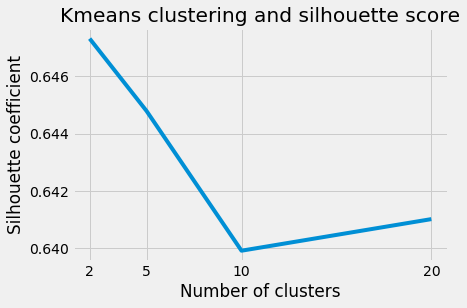

In [489]:
# Kmeans clustering and silhouette score
X, y = load_digits(return_X_y=True)
silhouette_coefficients = []
for i in n_components:
    new_x = TSNE(n_components=2).fit_transform(X)
    kmeans = cluster.KMeans(n_clusters=10)
    kmeans.fit(new_x)
    score = silhouette_score(new_x, kmeans.labels_)
    silhouette_coefficients.append(score)
    

plt.style.use("fivethirtyeight")
plt.plot(n_components, silhouette_coefficients)
plt.xticks(n_components)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.title("Kmeans clustering and silhouette score")
plt.show()

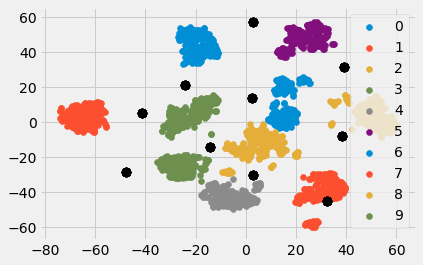

In [491]:
# Hierarchical clustering

# reduce dimensions

(n_samples, n_features), n_digits = X_embedded.shape, np.unique(y).size

ac = cluster.AgglomerativeClustering(n_clusters= 10)
label = ac.fit_predict(X_embedded)

# Getting unique labels
clf = NearestCentroid()
clf.fit(scaled_data, labels_ac)
centers = clf.centroids_
unique_labels = np.unique(label)

#plotting the results:
 
for i in unique_labels:
    plt.scatter(X_embedded[label == i , 0], X_embedded[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [ ]:
### This is shown above.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

In [ ]:
I think KMeans clustering works better than Agglomerative clustering. There are different parameters to consider of course.
Also, reducing dimensionality helps to improve the results.


**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.